In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Define dataset path and image size
dataset_path = "data"  # Path to your dataset
image_size = (224, 224)  # Resize to 224x224 for EfficientNetV2S

In [2]:
# Function to load images from the folder
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        # Skip folders with 'IriTech' or similar
        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Resize image to 224x224x3 for EfficientNetV2
                            img = cv2.resize(img, image_size)
                            images.append(img)
                            # Binary label, '0' means Fit for Duty, others alcoholic
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)


In [7]:
# Load dataset
images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")

# Preprocess data
images = np.array(images)
labels = np.array(labels)
images = images / 255.0  # Normalize images to [0, 1]
# Convert labels to categorical (one-hot encoding)
labels = to_categorical(labels, num_classes=2)

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 224, 224, 3)


In [8]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# Load pre-trained EfficientNetV2S model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Define the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 56s 1us/step


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7897 - loss: 0.5476 - val_accuracy: 0.7961 - val_loss: 0.5087
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7825 - loss: 0.5286 - val_accuracy: 0.7961 - val_loss: 0.5038
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7918 - loss: 0.5198 - val_accuracy: 0.7961 - val_loss: 0.5103
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7933 - loss: 0.5230 - val_accuracy: 0.7961 - val_loss: 0.5041
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8022 - loss: 0.4972 - val_accuracy: 0.7961 - val_loss: 0.5046
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7910 - loss: 0.5223 - val_accuracy: 0.7961 - val_loss: 0.5045
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7970 - loss: 0.5137 - val_accuracy: 0.7961 - val_loss: 0.5062
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7952 - loss: 0.5195 - val_accuracy: 0.7961 - v

18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.80      1.00      0.89       449

    accuracy                           0.80       564
   macro avg       0.40      0.50      0.44       564
weighted avg       0.63      0.80      0.71       564



c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


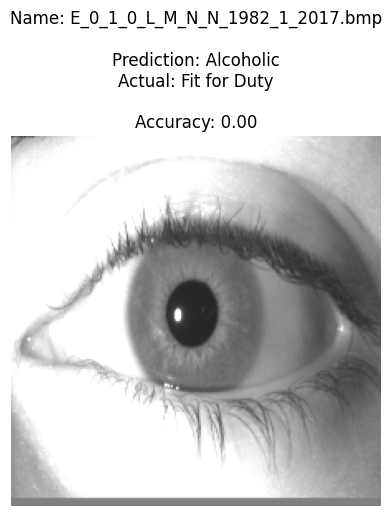

In [17]:
import random
from matplotlib import pyplot as plt

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Initialize test counter
totalTest = 0
correctTest = 0

# Test on a random image from the test set
def test_random_image():
    global totalTest, correctTest

    # Select a random index from the test set
    random_index = random.randint(0, len(X_test) - 1)
    testImg = X_test[random_index]
    testLabel = y_test_classes[random_index]

    # Resize the image to the target size for the model
    testImg = cv2.resize(testImg, image_size)

    # Display the image
    plt.imshow(testImg)
    plt.axis('off')

    # Add batch dimension and normalize the image for prediction
    testImg = np.expand_dims(testImg, axis=0)

    # Predict the label for the image
    prediction = model.predict(testImg)
    prediction = np.argmax(prediction[0])

    # Update counters
    totalTest += 1
    correctTest += prediction == testLabel

    # Map prediction and test label to 'Alcoholic' or 'Fit for Duty'
    prediction = 'Alcoholic' if prediction == 1 else 'Fit for Duty'
    testLabel = 'Alcoholic' if testLabel == 1 else 'Fit for Duty'

    # Set the title with the name, prediction, and actual label
    plt.title(f'Name: {names[random_index]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest / totalTest:.2f}')
    plt.show()

# Test on a random image from the test set
test_random_image()